In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient
from IPython.display import display
from mplsoccer import Pitch
import utils

In [177]:
MONGO_URI = "mongodb://localhost:27017/"
DB_NAME = "football_data"

client = MongoClient(MONGO_URI)
db = client[DB_NAME]
lineups = pd.DataFrame(list(db.lineups.find()))

In [178]:
def calculate_minutes(events, starting_events, player_id):
    minutes = 0
    match_ids = events['match_id'].unique()

    for match_id in match_ids:
        match_events = events[events['match_id'] == match_id]

        #zaczyna
        match_start = starting_events[starting_events['match_id'] == match_id]
        started = False

        if not match_start.empty:
            lineup = match_start.iloc[0].get('tactics', {}).get('lineup', [])
            if any(player['player']['id'] == player_id for player in lineup):
                started = True

        #wchodzi
        sub_out = match_events[
            (match_events['type'] == 'Substitution') &
            (match_events.get('player_id') == player_id if 'player_id' in match_events.columns else False)
        ]

        #schodzi
        if 'substitution_replacement_id' in match_events.columns:
            sub_in = match_events[
                (match_events['type'] == 'Substitution') &
                (match_events['substitution_replacement_id'] == player_id)
            ]
        else:
            sub_in = pd.DataFrame()

        if started:
            if not sub_out.empty:
                minutes += sub_out.iloc[0]['minute']
            else:
                minutes += 90
        elif not started and not sub_in.empty:
            minutes += (90 - sub_in.iloc[0]['minute'])

    return minutes

In [179]:
name = 'Jan Oblak'

player_row = lineups[
    (lineups['player_name'].str.lower() == name.lower()) |
    (lineups['player_nickname'].str.lower() == name.lower())
]
player_id = player_row.iloc[0]['player_id']
full_name = player_row.iloc[0]['player_name']
team = player_row.iloc[0]['team']
lineups = lineups[lineups['player_id'] == player_id]
player_id = int(player_row.iloc[0]['player_id'])
country = player_row.iloc[0]['country']
jersey = player_row.iloc[0]['jersey_number']
nickname = player_row.iloc[0]['player_nickname']
if nickname is None:
    nickname = full_name

query = {
    '$or': [
        {'player_id': player_id},
        {'pass_recipient_id': player_id},
        {'substitution_replacement_id': player_id},
        ]
    }

events = pd.DataFrame(list(db.events.find(query)))
starting_events = pd.DataFrame(list(db.events.find({'type': 'Starting XI', 'team': team}))) #wyjściowe 11stki
matches = pd.DataFrame(list(db.matches.find({'team' : team})))
events, lineups = utils.apply_nicknames(events, lineups, starting_events=starting_events) #zmiana pełnych nazwisk na te które każdy zna

In [180]:
print(f"Full Name: {full_name}")
print(f"Nickname: {nickname}")
print(f"Nationality: {country}")
print(f"Jersey number: {jersey}")
print(f"Team: {team}")

minutes_played = calculate_minutes(events, starting_events, player_id)
print(f"Minutes played: {minutes_played}")
#Pozycje ze składów wyjściowych
position_counts = {}

for _, row in starting_events.iterrows():
    lineup = row.get('tactics', {}).get('lineup', [])
    for p in lineup:
        if p['player']['id'] == player_id:
            pos = p['position']['name']
            position_counts[pos] = position_counts.get(pos, 0) + 1

starting_appearances = sum(position_counts.values())
try:
    sub_appearances = len(events[
        (events['type'] == 'Substitution') &
        (events['substitution_replacement_id'] == player_id)
    ])
except:
    sub_appearances = 0
total_appearances = starting_appearances + sub_appearances
print(f"Starting gappearances: {starting_appearances}")
print(f"Sub-ins: {sub_appearances}")
print("Positions:")
for pos, count in sorted(position_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"    {pos}: {count}")



Full Name: Jan Oblak
Nickname: Jan Oblak
Nationality: Slovenia
Jersey number: 13
Team: Atlético Madrid
Minutes played: 3420
Starting gappearances: 38
Sub-ins: 0
Positions:
    Goalkeeper: 38


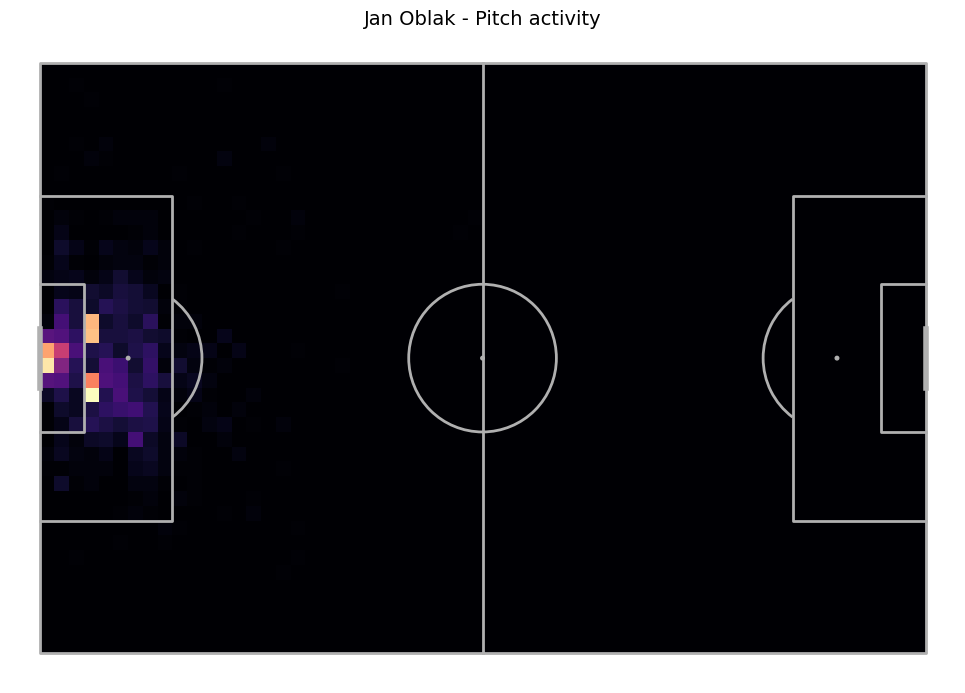

In [181]:
player_events = events[
    (events['player_id'] == player_id) & 
    events['location'].notna()
].copy()

player_events['x'] = player_events['location'].apply(lambda loc: loc[0])
player_events['y'] = player_events['location'].apply(lambda loc: loc[1])

pitch = Pitch(pitch_type='statsbomb', line_zorder=2)
fig, ax = pitch.draw(figsize=(10, 7))

bin_stat = pitch.bin_statistic(player_events['x'], player_events['y'], statistic='count', bins=(60, 40))
pitch.heatmap(bin_stat, ax=ax, cmap='magma')
ax.set_title(f'{nickname} - Pitch activity', fontsize=14)

plt.show()

In [182]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt

shots = events[
    (events['type'] == 'Shot') &
    (events['player_id'] == player_id) &
    events['location'].notna()
].copy()
if shots.empty:
    print(f"{nickname} has 0 shots")
else:
    shots['x'] = shots['location'].apply(lambda loc: loc[0])
    shots['y'] = shots['location'].apply(lambda loc: loc[1])

    goal_outcomes = ['Goal']
    on_target_outcomes = ['Saved', 'Saved to Post', 'Saved Off Target']
    off_target_outcomes = ['Off T', 'Blocked', 'Post', 'Wayward']

    def classify_shot(outcome):
        if outcome in goal_outcomes:
            return 'Goal'
        elif outcome in on_target_outcomes:
            return 'On Target'
        else:
            return 'Off Target'

    shots['category'] = shots['shot_outcome'].apply(classify_shot)

    shots_goal = shots[shots['category'] == 'Goal']
    shots_on = shots[shots['category'] == 'On Target']
    shots_off = shots[shots['category'] == 'Off Target']

    pitch = Pitch(pitch_type='statsbomb', line_zorder=2)
    fig, ax = pitch.draw(figsize=(10, 7))

    pitch.scatter(
        shots_goal['x'], shots_goal['y'], ax=ax,
        color='red', marker='*', s=200,
        edgecolors='black', linewidth=1, alpha=1.0,
        label='Goal'
    )

    pitch.scatter(
        shots_on['x'], shots_on['y'], ax=ax,
        color='blue', marker='D', s=50,
        edgecolors='black', linewidth=1, alpha=0.8,
        label='On target'
    )

    pitch.scatter(
        shots_off['x'], shots_off['y'], ax=ax,
        color='gray', marker='o', s=50,
        edgecolors='black', linewidth=1, alpha=0.3,
        label='Off target'
    )

    ax.set_title(f"{nickname} - Shots", fontsize=14)
    ax.legend(loc='upper right')
    plt.show()


Jan Oblak has 0 shots
